# Applying ridge estimation to Chicago crime data

The ridge estimation approach of DREDGE is applied to Part I crimes as defined by the [Unified Crime Reporting](https://www.ucrdatatool.gov/offenses.cfm) framework. In the below application example, the latitude-longitude data is drawn from the [Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), limiting the dataset to Part I crimes from 2018.

First, we import the libraries necessary for running this notebook.

In [ ]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import pickle
import timeit

### Preparing the data

Next, we load the full data downlaoded from the [Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2) and retain only four entries: The primary crime type, the year of the incident report, and the latitude and longitude coordinate per report. We then save the reduced data as a pickled (PKL) file.

In [3]:
# Specify the file path to the raw data
file_path = 'crimes_chicago.csv'
# Specify the file name for clean data
clean_name = 'cleaned_data'

# Load the data into a pandas DataFrame
raw_data = pd.read_csv(file_path)
# Extract the desired feature columns
cut_data = raw_data[['Primary Type', 'Year', 'Latitude', 'Longitude']]
# Delete data points with NaN entries
clean_data = cut_data.dropna()

# Pickle the clean data for storage
clean_data.to_pickle(clean_name + '.pkl')

As we don't want to load the whole dataset again in case we decide to restart the kernel of this notebook, we can now simply load the saved file.

In [4]:
# Specify the file path to the data
file_path = 'cleaned_data.pkl'

# Load the data into a pandas DataFrame
data = pd.read_pickle(file_path)

This example case focuses on Part I crimes, which are eight crime types split into four property offenses and four violent offenses.These two sets correspond to the first and remaining four crime types listed below, respectively. We then retain only entries from the year 2018 that fall under these offenses and sample a subset of 5000 crime incident reports to extract a representative sample from the remaining dataset.

In [5]:
# Specify the crime type(s) of interest
crimes = ['ROBBERY', 
          'THEFT', 
          'BURGLARY', 
          'MOTOR VEHICLE THEFT', 
          'ASSAULT', 
          'CRIM SEXUAL ASSAULT', 
          'ARSON', 
          'HOMICIDE'
         ]

# Specify the allowable year interval
years = [2018, 2018]

# Extract the subset of data based on the crime type(s)
data = data.loc[data['Primary Type'].isin(crimes)]
# Extract the subset of data based on the allowable years
data = data.loc[data['Year'].between(years[0], years[1])]

# Use unfiformly-random sampling for a subset
data = data.sample(n = 5000, random_state = 42)

In the next step, we pull the latitude and longitude arrays from the dataset, and combine them into a two-row matrix in which each row represents one location associated with a crime incident report.

In [22]:
# Extract latitudes from the dataset
data_lat = np.asarray(data['Latitude'])
# Extract longitudes from the dataset
data_long = np.asarray(data['Longitude'])
# Merge the two arrays to a coordinatex matrix
coordinates = np.vstack((data_lat, data_long)).T

### Running DREDGE for full ridges

DREDGE is built to be easy to import and use. For this reason, we can simply import it and call its primary function, `filaments()`. While optional parameters are available, we will only use the mandatory input, meaning the set of coordinates, to show the functionality of the provided package.

In [4]:
# Import the main DREDGE function locally
from dredge import filaments

# Start a timer
start = timeit.default_timer()
# Compute the density ridge estimates
ridges = filaments(coordinates)
# Stop the timing and print the time
stop = timeit.default_timer()
print('Time: ', stop - start)  

Input parameters valid!

Preparing for iterations ...

Automatically computed bandwidth: 0.003307

Iteration 1 ...
Iteration 2 ...
Iteration 3 ...
Iteration 4 ...
Iteration 5 ...
Iteration 6 ...
Iteration 7 ...
Iteration 8 ...
Iteration 9 ...
Iteration 10 ...
Iteration 11 ...
Iteration 12 ...
Iteration 13 ...
Iteration 14 ...
Iteration 15 ...
Iteration 16 ...
Iteration 17 ...
Iteration 18 ...
Iteration 19 ...
Iteration 20 ...
Iteration 21 ...
Iteration 22 ...
Iteration 23 ...
Iteration 24 ...
Iteration 25 ...
Iteration 26 ...
Iteration 27 ...
Iteration 28 ...
Iteration 29 ...
Iteration 30 ...
Iteration 31 ...
Iteration 32 ...
Iteration 33 ...
Iteration 34 ...
Iteration 35 ...
Iteration 36 ...

Done!
Time:  385.81796533300076


### Plot the coordinates and full ridges

At this point, we have the set of coordinates that indicate the filament lines. The below code simply plots both the previously sampled crime report incidents in cyan and the density ridges in red, and also surrounds each crime report incident with a larger circle in light cyan to show the general shape of Chicago, reflected through crime reports. On the right side and the top of the plot, 1D histograms for the crime distribution are provided.

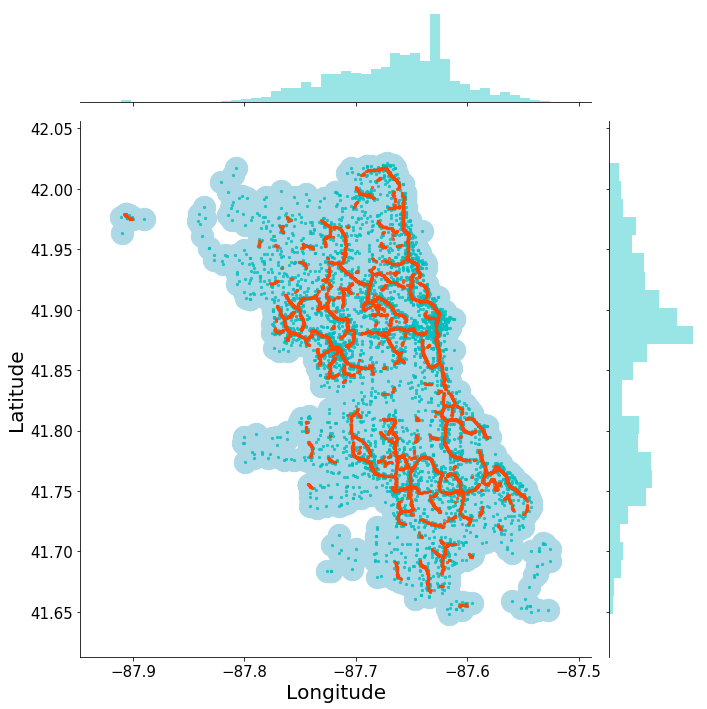

In [5]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
import warnings

# Deactivate deprecated version warning
warnings.filterwarnings('ignore')

# Convert the datasets to pandas dataframes
coordinates_df = pd.DataFrame(dict(longitude = coordinates[:, 1], 
                                   latitude = coordinates[:, 0]))
ridges_df = pd.DataFrame(dict(longitude = ridges[:, 1], 
                              latitude = ridges[:, 0]))

# Prepare the figure size for plotting
latitude_diff = np.abs(np.max(coordinates[:, 0]) 
                       - np.min(coordinates[:, 0]))
longitude_diff = np.abs(np.max(coordinates[:, 1]) 
                        - np.min(coordinates[:, 1]))
scaling_ratio = latitude_diff / longitude_diff
x_axis = 10
y_axis = x_axis * scaling_ratio

# Plot the figure
g = sns.jointplot("latitude", 
                   "longitude", 
                   data = coordinates_df,
                   color = 'c', 
                   kind = 'scatter', 
                   joint_kws={"s": 5},
                   alpha = 0.75,
                   ratio = 5).plot_joint(plt.scatter, 
                                         zorder = 0, 
                                         color = 'lightblue',
                                         s=500)

g.fig.set_figwidth(x_axis)
g.fig.set_figheight(y_axis)
#g.ax_joint.legend_.remove()

g = sns.regplot("latitude", 
                "longitude", 
                data = ridges_df,
                color = 'orangered',
                fit_reg = False,
                marker = 'o', 
                scatter_kws = {'s':5.0})

g.set_xlabel('Longitude',fontsize = 20)
g.set_ylabel('Latitude', fontsize = 20)
g.tick_params(labelsize = 15)


# Show the created plot
plt.show()

### Save the coordinates and ridge estimates

The crime incident report sample used so far can be saved, as can the ridges plotted above.

In [27]:
# Import the necessary libraries
import numpy as np

# Save the latitude-longitude samples
np.savetxt("coordinate_samples.csv", coordinates, delimiter = ',')

# Save the density ridge estimates
np.savetxt("ridges_full.csv", ridges, delimiter = ',')

### Run DREDGE for cut-off ridges

We now repeat the DREDGE run with the same data as before, but we make use of one of DREDGE's optional parameters, namely the ability to only retain ridges for top-percentages. Visually, this process can be imagined as horizontally cutting the density landscape at a given percentile, for example the 95$^{\mathrm{th}}$ percentile for the input `percentage = 5`, and extracting the ridges that are located on these mountaintops.

In [7]:
# Import the necessary libraries
import timeit

# Import the main DREDGE function locally
from dredge import filaments

# Start a timer
start = timeit.default_timer()
# Compute the density ridge estimates
ridges = filaments(coordinates, percentage = 5)
# Stop the timing and print the time
stop = timeit.default_timer()
print('Time: ', stop - start)  

Input parameters valid!

Preparing for iterations ...

Automatically computed bandwidth: 0.003307

Iteration 1 ...
Iteration 2 ...
Iteration 3 ...
Iteration 4 ...
Iteration 5 ...
Iteration 6 ...
Iteration 7 ...
Iteration 8 ...
Iteration 9 ...
Iteration 10 ...
Iteration 11 ...
Iteration 12 ...
Iteration 13 ...
Iteration 14 ...
Iteration 15 ...
Iteration 16 ...
Iteration 17 ...
Iteration 18 ...
Iteration 19 ...
Iteration 20 ...
Iteration 21 ...
Iteration 22 ...
Iteration 23 ...
Iteration 24 ...
Iteration 25 ...
Iteration 26 ...
Iteration 27 ...
Iteration 28 ...
Iteration 29 ...
Iteration 30 ...
Iteration 31 ...
Iteration 32 ...
Iteration 33 ...
Iteration 34 ...
Iteration 35 ...
Iteration 36 ...
Iteration 37 ...
Iteration 38 ...

Done!
Time:  421.03087381797377


### Plot the coordinates and cut-off ridges

We then use the same code as before, with the same color coding and plotted coordinates.

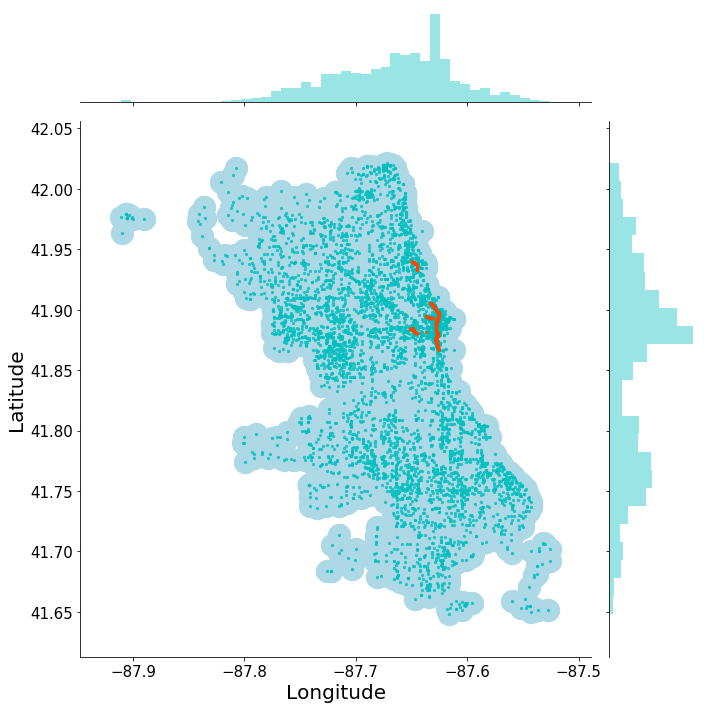

In [8]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
import warnings

# Deactivate deprecated version warning
warnings.filterwarnings('ignore')

# Convert the datasets to pandas dataframes
coordinates_df = pd.DataFrame(dict(longitude = coordinates[:, 1], 
                                   latitude = coordinates[:, 0]))
ridges_df = pd.DataFrame(dict(longitude = ridges[:, 1], 
                              latitude = ridges[:, 0]))

# Prepare the figure size for plotting
latitude_diff = np.abs(np.max(coordinates[:, 0]) 
                       - np.min(coordinates[:, 0]))
longitude_diff = np.abs(np.max(coordinates[:, 1]) 
                        - np.min(coordinates[:, 1]))
scaling_ratio = latitude_diff / longitude_diff
x_axis = 10
y_axis = x_axis * scaling_ratio

# Plot the figure
g = sns.jointplot("latitude", 
                   "longitude", 
                   data = coordinates_df,
                   color = 'c', 
                   kind = 'scatter', 
                   joint_kws={"s": 5},
                   alpha = 0.75,
                   ratio = 5).plot_joint(plt.scatter, 
                                         zorder = 0, 
                                         color = 'lightblue',
                                         s=500)

g.fig.set_figwidth(x_axis)
g.fig.set_figheight(y_axis)
#g.ax_joint.legend_.remove()

g = sns.regplot("latitude", 
                "longitude", 
                data = ridges_df,
                color = 'orangered',
                fit_reg = False,
                marker = 'o', 
                scatter_kws = {'s':5.0})

g.set_xlabel('Longitude',fontsize = 20)
g.set_ylabel('Latitude', fontsize = 20)
g.tick_params(labelsize = 15)


# Show the created plot
plt.show()

### Save the ridge estimates

As before, these ridges can be saved. We don't need to save the coordinates again, as they're the same as above.

In [9]:
# Import the necessary libraries
import numpy as np

# Save the density ridge estimates
np.savetxt("ridges_cut.csv", ridges, delimiter = ',')